## Objective
This notebook performs comprehensive feature analysis to understand our dataset's characteristics and select the most relevant features for our **apartment price prediction model**. We build upon the initial data exploration to make data-driven decisions about feature transformations, selection, and augmentation strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from scipy import stats

plt.rcParams['font.family'] = ['Arial Unicode MS', 'Tahoma', 'Arial', 'sans-serif']

In [2]:
df = pd.read_csv("Apartments.csv", encoding = 'utf-8-sig')
df.head(10)
df_og = df.copy()

In [3]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 37


In [4]:
df = df.drop_duplicates()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 0 to 678
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   642 non-null    object
 1   المدينة         642 non-null    object
 2   الحي / المنطقة  642 non-null    object
 3   عدد الغرف       642 non-null    int64 
 4   عدد الحمامات    642 non-null    int64 
 5   مفروشة          642 non-null    int64 
 6   مساحة البناء    642 non-null    int64 
 7   الطابق          642 non-null    object
 8   عمر البناء      642 non-null    int64 
 9   العقار مرهون    642 non-null    object
 10  طريقة الدفع     642 non-null    int64 
 11  مصعد            642 non-null    object
 12  موقف سيارات     642 non-null    object
dtypes: int64(6), object(7)
memory usage: 70.2+ KB


In [6]:
# convert price to integer values
df['السعر بالشيكل'] = df["السعر بالشيكل"].astype(str).str.replace('"', '', regex=False).str.replace(",", "", regex=False)
df['السعر بالشيكل'] = pd.to_numeric(df['السعر بالشيكل'])
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,F,0,T,T


In [7]:
# Map T/F to True/False boolean values
bool_map = {'T': True, 'F': False}
pd.set_option('future.no_silent_downcasting', True)
for col in ["العقار مرهون", "مصعد", "موقف سيارات"]:
    df[col] = df[col].replace({'T': True, 'F': False}).astype(bool)
df.head(1)

,السعر بالشيكل,المدينة,الحي / المنطقة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,المخفية,3,2,0,138,2,2,False,0,True,True


In [8]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

### Detecting Outliers in Price & Area

In [9]:
# Price
prices = df['السعر بالشيكل']
z_scores = np.abs(stats.zscore(prices))
outlier_mask = z_scores > 3
outlier_count = outlier_mask.sum()

print("\nZ-SCORE OUTLIER DETECTION")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count)

print("\nTop high price outliers:")
print(df[outlier_mask].sort_values('السعر بالشيكل', ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", 'السعر بالشيكل', "عدد الغرف"]]
      .head(10))
#drop outliers
df = df[~outlier_mask]


Z-SCORE OUTLIER DETECTION
Threshold: |z| > 3
Outliers found: 2

Top high price outliers:
              المدينة الحي / المنطقة  مساحة البناء  السعر بالشيكل  عدد الغرف
320  رام الله والبيرة        بيتونيا           160       37095996          3
345             القدس           حزما           142       10000000          3


In [10]:
# Area
areas = df["مساحة البناء"]
z_scores_area = np.abs(stats.zscore(areas))
outlier_mask_area = z_scores_area > 3
outlier_count_area = outlier_mask_area.sum()

print("\nZ-SCORE OUTLIER DETECTION — AREA")
print(f"Threshold: |z| > 3")
print("Outliers found:", outlier_count_area)

print("\nTop large area outliers:")
print(df[outlier_mask_area].sort_values("مساحة البناء", ascending=False)
      [["المدينة", "الحي / المنطقة", "مساحة البناء", "عدد الغرف", "السعر بالشيكل"]]
      .head(10))
#drop outliers
df = df[~outlier_mask_area]


Z-SCORE OUTLIER DETECTION — AREA
Threshold: |z| > 3
Outliers found: 6

Top large area outliers:
              المدينة الحي / المنطقة  مساحة البناء  عدد الغرف  السعر بالشيكل
423  رام الله والبيرة         الطيرة          1802          3         556440
417  رام الله والبيرة         الطيرة          1240          3        5007960
318  رام الله والبيرة        بير زيت          1000          3         593536
164  رام الله والبيرة       عين عريك           750          3         300000
446  رام الله والبيرة        بيتونيا           600          6         650000
356  رام الله والبيرة        بير زيت           500          5        1409648


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 0 to 678
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   السعر بالشيكل   634 non-null    int64 
 1   المدينة         634 non-null    object
 2   الحي / المنطقة  634 non-null    object
 3   عدد الغرف       634 non-null    int64 
 4   عدد الحمامات    634 non-null    int64 
 5   مفروشة          634 non-null    int64 
 6   مساحة البناء    634 non-null    int64 
 7   الطابق          634 non-null    object
 8   عمر البناء      634 non-null    int64 
 9   العقار مرهون    634 non-null    bool  
 10  طريقة الدفع     634 non-null    int64 
 11  مصعد            634 non-null    bool  
 12  موقف سيارات     634 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 56.3+ KB


### Skewness Check

📊 Skewness for Numeric Features:
مساحة البناء: 1.31


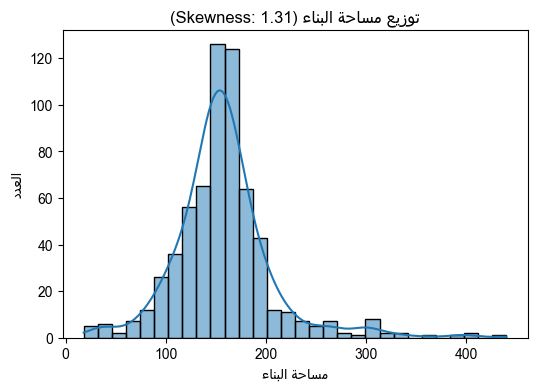

السعر بالشيكل: 5.52


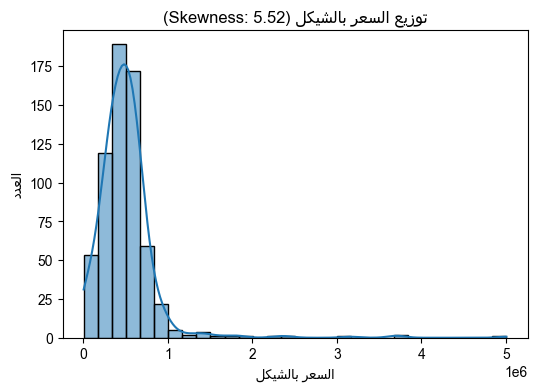

In [12]:
# Select numeric columns
target_cols = ["مساحة البناء", "السعر بالشيكل"]

print("📊 Skewness for Numeric Features:")
for col in target_cols:
    skew_val = df[col].skew()
    print(f"{col}: {skew_val:.2f}")
    
    # Plot histogram + KDE
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(process_arabic_text(f"توزيع {col} (Skewness: {skew_val:.2f})"))
    plt.xlabel(process_arabic_text(col))
    plt.ylabel(process_arabic_text("العدد"))
    plt.show()

We observe that the price and area distributions are highly right-skewed, so we will apply the appropriate transformations to them.

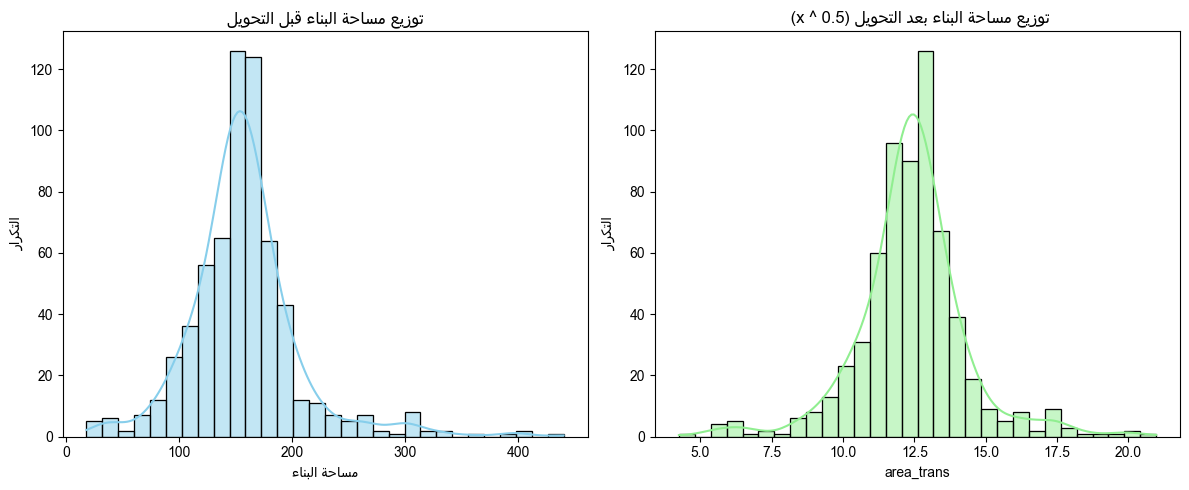

AREA SKEWNESS COMPARISON:
Original skewness:    1.31
Transformed skewness: 0.06
Improvement:          1.25


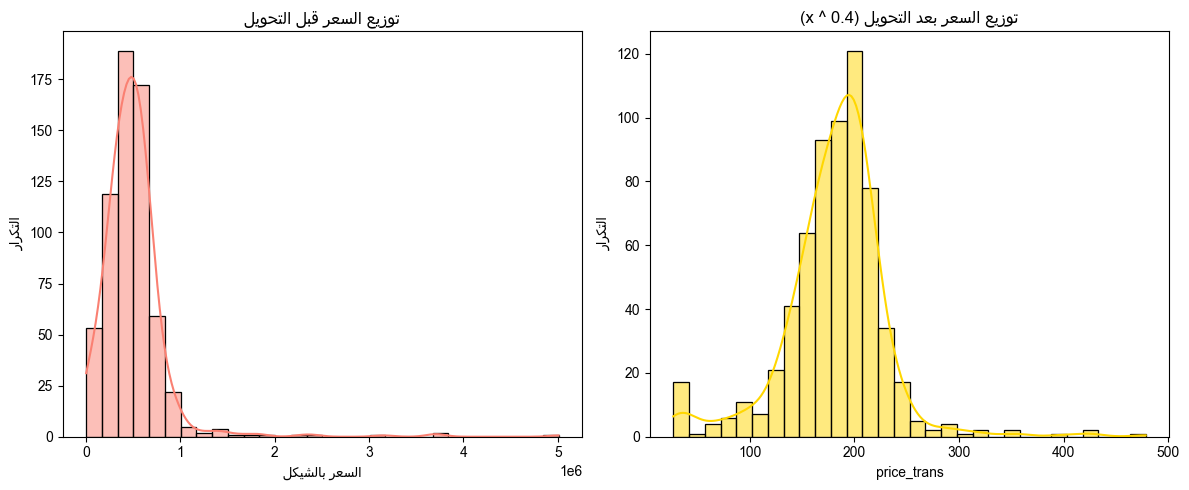

PRICE SKEWNESS COMPARISON:
Original skewness:    5.52
Transformed skewness: 0.20
Improvement:          5.32


In [13]:
original_area_skew = df['مساحة البناء'].skew()
df['area_trans'] = (df['مساحة البناء']) ** 0.5
transformed_area_skew = df['area_trans'].skew()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['مساحة البناء'], kde=True, bins=30, color='skyblue')
plt.title(process_arabic_text('توزيع مساحة البناء قبل التحويل'))
plt.xlabel(process_arabic_text('مساحة البناء'))
plt.ylabel(process_arabic_text('التكرار'))

plt.subplot(1, 2, 2)
sns.histplot(df['area_trans'], kde=True, bins=30, color='lightgreen')
plt.title(process_arabic_text('توزيع مساحة البناء بعد التحويل (x ^ 0.5) '))
plt.xlabel(process_arabic_text('area_trans'))
plt.ylabel(process_arabic_text('التكرار'))

plt.tight_layout()
plt.show()

print("="*50)
print("AREA SKEWNESS COMPARISON:")
print(f"Original skewness:    {original_area_skew:.2f}")
print(f"Transformed skewness: {transformed_area_skew:.2f}")
print(f"Improvement:          {original_area_skew - transformed_area_skew:.2f}")
print("="*50)

original_price_skew = df['السعر بالشيكل'].skew()
df['price_trans'] = df["السعر بالشيكل"] ** 0.4
transformed_price_skew = df['price_trans'].skew()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["السعر بالشيكل"], kde=True, bins=30, color='salmon')
plt.title(process_arabic_text("توزيع السعر قبل التحويل"))
plt.xlabel(process_arabic_text("السعر بالشيكل"))
plt.ylabel(process_arabic_text("التكرار"))

plt.subplot(1, 2, 2)
sns.histplot(df['price_trans'], kde=True, bins=30, color='gold')
plt.title(process_arabic_text("توزيع السعر بعد التحويل (x ^ 0.4)"))
plt.xlabel(process_arabic_text("price_trans"))
plt.ylabel(process_arabic_text("التكرار"))

plt.tight_layout()
plt.show()

print("="*50)
print("PRICE SKEWNESS COMPARISON:")
print(f"Original skewness:    {original_price_skew:.2f}")
print(f"Transformed skewness: {transformed_price_skew:.2f}")
print(f"Improvement:          {original_price_skew - transformed_price_skew:.2f}")
print("="*50)

### Relationship Between Target & Numeric Features

In [14]:
features = ["مساحة البناء", "عدد الغرف", "عدد الحمامات", "عمر البناء"]

pearson_corr = df[features + ["price_trans"]].corr(method='pearson')
spearman_corr = df[features + ["price_trans"]].corr(method='spearman')

summary = pd.DataFrame({
    'Pearson': pearson_corr["price_trans"],
    'Spearman': spearman_corr["price_trans"]
}).drop("price_trans") # Remove self-correlation

summary_sorted = summary.sort_values(by='Spearman', key=abs, ascending=False)


print("\n--- Correlation with Transformed Price ---")
print(summary_sorted.round(3))

features = ["مساحة البناء", "عدد الغرف", "عدد الحمامات", "عمر البناء"]


--- Correlation with Transformed Price ---
              Pearson  Spearman
مساحة البناء    0.348     0.465
عدد الحمامات    0.316     0.416
عدد الغرف       0.058     0.115
عمر البناء     -0.047    -0.066


The correlation results show that area and bathrooms have the strongest relationship with price, so we'll investigate these relationships more closely.

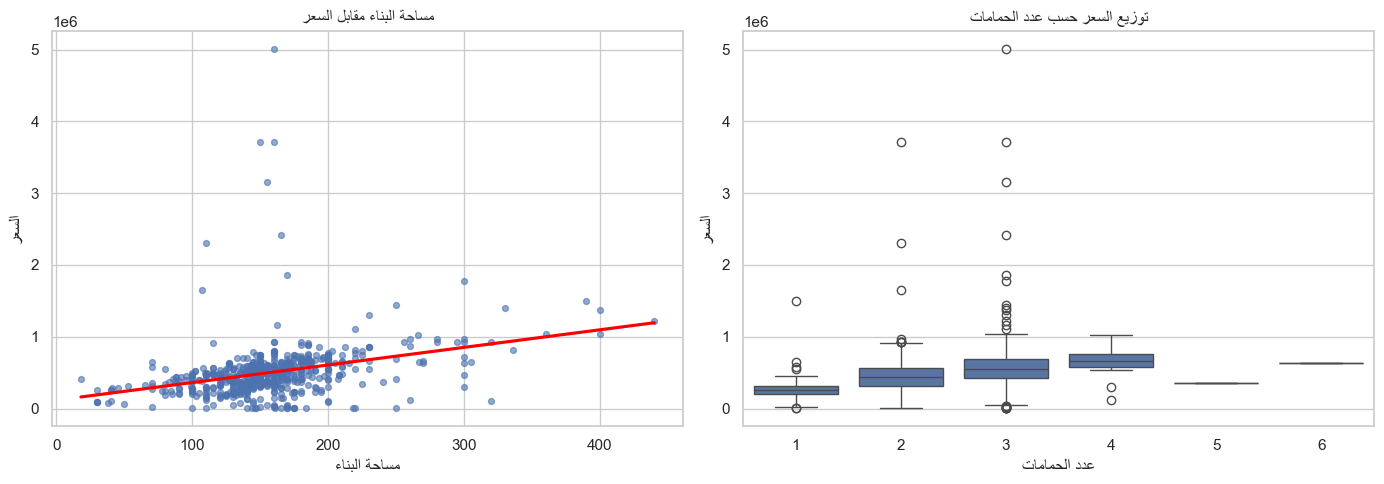

In [15]:
sns.set(style="whitegrid", font_scale=1.0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

x_area = df['مساحة البناء'].astype(float)
y = df['السعر بالشيكل'].astype(float)

ax1.scatter(x_area, y, s=18, alpha=0.6)
sns.regplot(x=x_area, y=y, scatter=False, ci=None, line_kws={"color":"red"}, ax=ax1)
ax1.set_xlabel(process_arabic_text("مساحة البناء"))
ax1.set_ylabel(process_arabic_text("السعر"))
ax1.set_title(process_arabic_text("مساحة البناء مقابل السعر"))

# Bathrooms box plot (right)
sns.boxplot(x='عدد الحمامات', y='السعر بالشيكل', data=df, ax=ax2)
ax2.set_xlabel(process_arabic_text("عدد الحمامات"))
ax2.set_ylabel(process_arabic_text("السعر"))
ax2.set_title(process_arabic_text("توزيع السعر حسب عدد الحمامات"))

plt.tight_layout()
plt.show()

### Category Counts & Cardinality Check
This will be useful to keep in mind when it comes to augmentaion and data synthesis, so we can know the distribution to try and maintain

In [16]:
floor_mapping = {
    'G': 0,  # ارضي
    'B': -1, # شبه ارضي
    'P': -2,  # التسوية
    'R': 11 # Roof
}
df['الطابق'] = df['الطابق'].replace(floor_mapping)

df['الطابق'] = pd.to_numeric(df['الطابق'])


Feature: المدينة
Value counts:
  رام الله والبيرة: 388
  نابلس: 94
  بيت لحم: 49
  طولكرم: 26
  جنين: 24
  الخليل: 24
  القدس: 19
  أريحا: 4
  قلقيلية: 3
  سلفيت: 2
  طوباس: 1

Total unique values: 11
Most common: رام الله والبيرة (388 occurrences)
Least common: طوباس (1 occurrences)


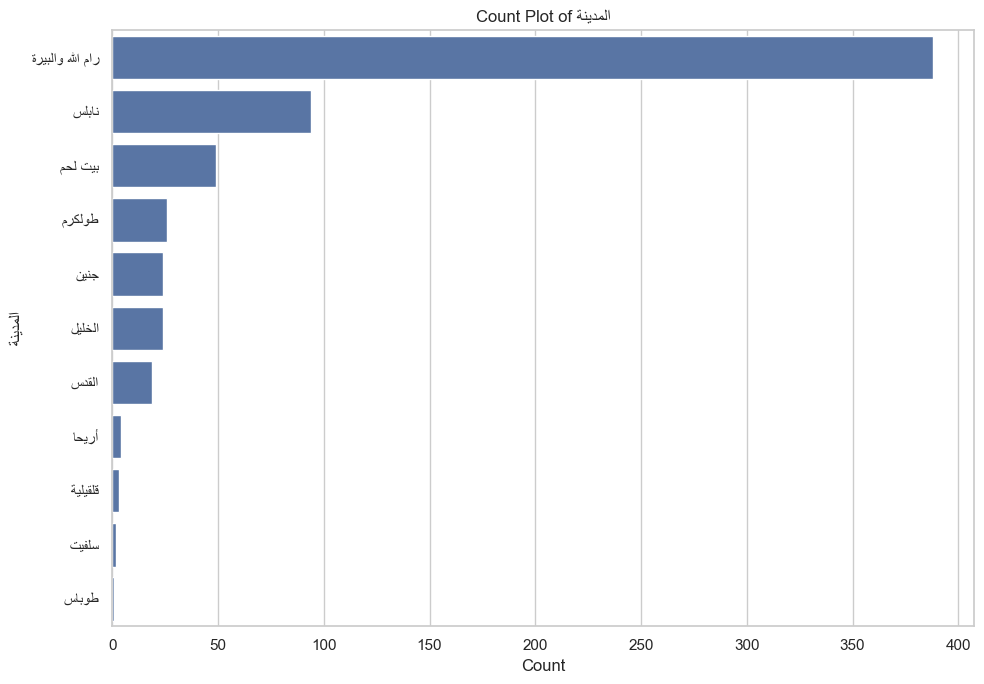


Feature: الحي / المنطقة
Value counts:
  الطيرة: 74
  بيتونيا: 46
  البالوع: 34
  الماصيون: 29
  عين مصباح: 28
  ش. الارسال: 26
  أخرى: 23
  عين منجد: 21
  سطح مرحبا: 16
  رفيديا: 16
  سردا: 14
  بير زيت: 14
  بيت جالا: 14
  الجبل الشمالي: 12
  ضاحية الريحان: 12
  الدوحة: 11
  ام الشرايط: 10
  ش. القدس: 9
  التحتا: 8
  بطن الهوى: 8
  الجبل الجنوبي: 7
  المخفية: 7
  بيت ساحور: 6
  روابي: 6
  كفر عقب: 6
  بيت ايبا: 6
  وسط البلد: 6
  الشرفة: 5
  ابو ديس: 5
  الحرس: 5
  دار صلاح: 5
  ش. حيفا: 5
  الحي الجنوبي: 5
  بيت وزن: 5
  حي المعاجين: 4
  ش. التعاون: 4
  نابلس الجديدة: 4
  الجامعة الامريكية: 4
  شويكة: 4
  صانور: 3
  ش. عمان: 3
  الحي الشمالي: 3
  ش. نابلس: 3
  الخضر: 3
  الجابريات: 3
  الحي الشرقي: 3
  راس الجوزة: 3
  جبل هندازة: 2
  الضاحية: 2
  عقبة تفوح: 2
  ارتاح: 2
  جناتا: 2
  مراح السعد: 2
  الجنيد: 2
  جبل الرحمة: 2
  ش. تل: 2
  ذنابة: 2
  ش. الصف: 2
  ش. جامعة النجاح: 2
  ش. المنتزه: 2
  حزما: 2
  بير نبالا: 2
  واد التفاح: 2
  المساكن الشعبية: 2
  كفر زيباد: 1
  قوصين: 1
 

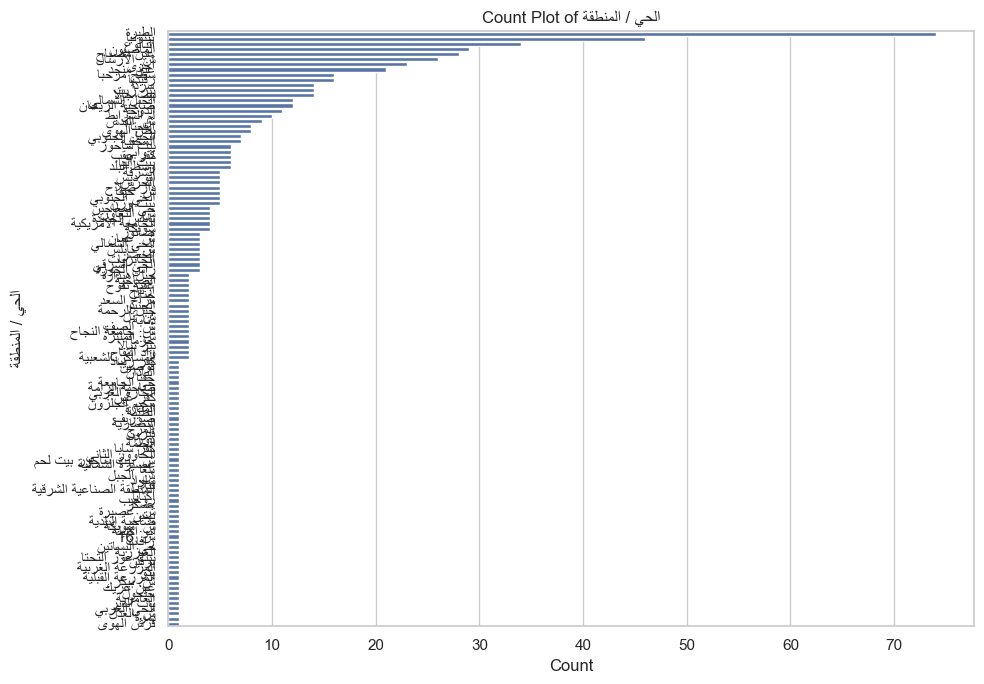


Feature: مفروشة
Value counts:
  0: 517
  1: 91
  2: 26

Total unique values: 3
Most common: 0 (517 occurrences)
Least common: 2 (26 occurrences)


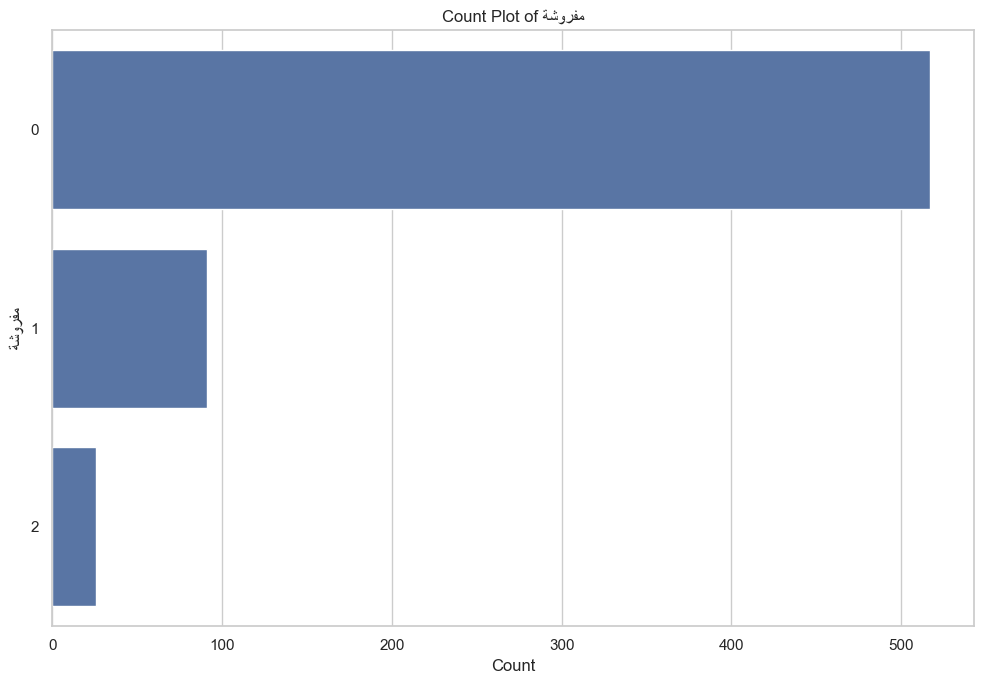


Feature: العقار مرهون
Value counts:
  False: 615
  True: 19

Total unique values: 2
Most common: False (615 occurrences)
Least common: True (19 occurrences)


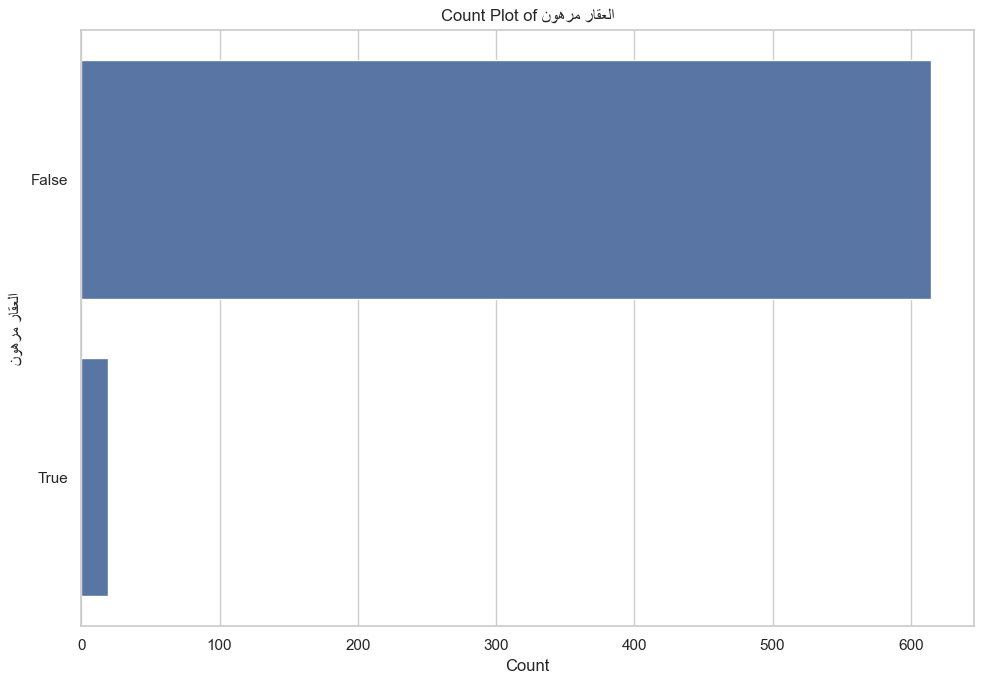


Feature: مصعد
Value counts:
  True: 513
  False: 121

Total unique values: 2
Most common: True (513 occurrences)
Least common: False (121 occurrences)


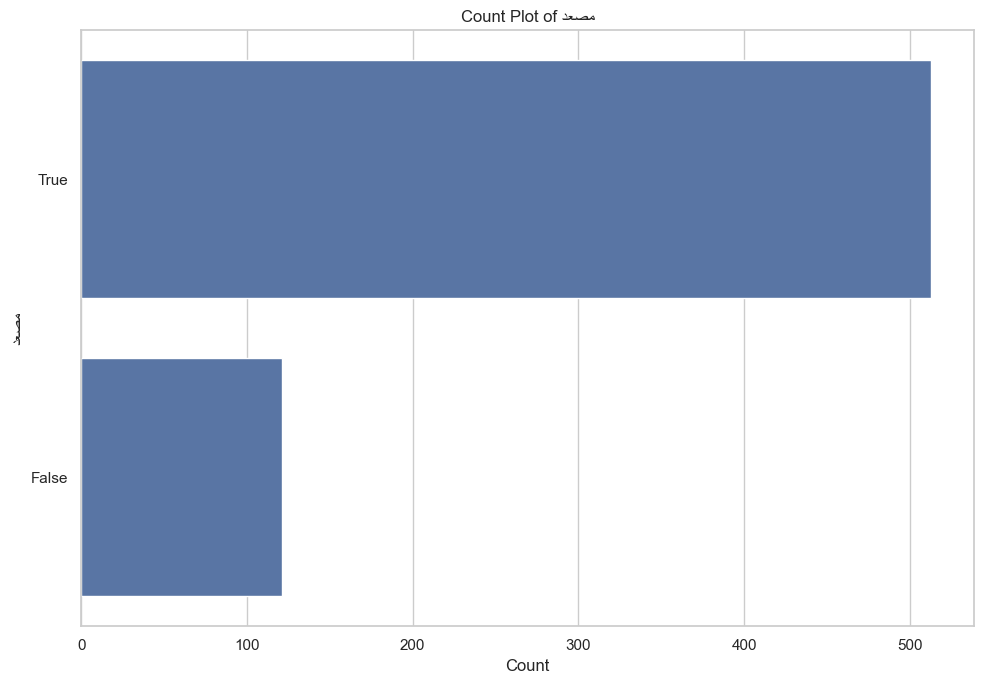


Feature: موقف سيارات
Value counts:
  True: 502
  False: 132

Total unique values: 2
Most common: True (502 occurrences)
Least common: False (132 occurrences)


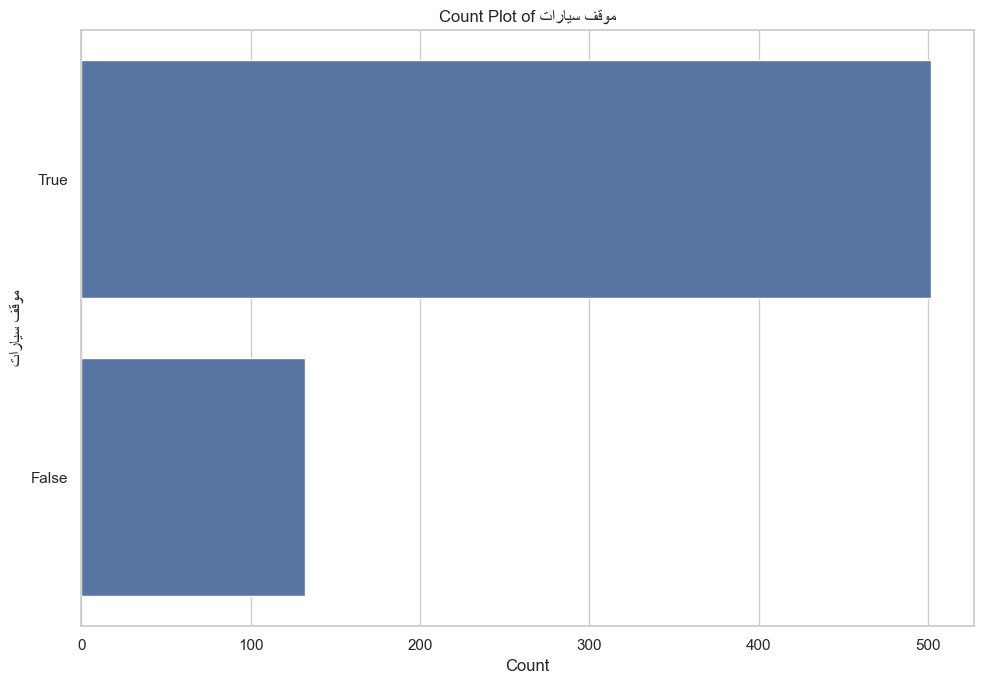


Feature: الطابق
Value counts:
  4: 144
  3: 122
  1: 111
  2: 82
  0: 72
  -1: 30
  6: 20
  11: 15
  -2: 12
  8: 6
  5: 6
  7: 6
  9: 5
  10: 3

Total unique values: 14
Most common: 4 (144 occurrences)
Least common: 10 (3 occurrences)


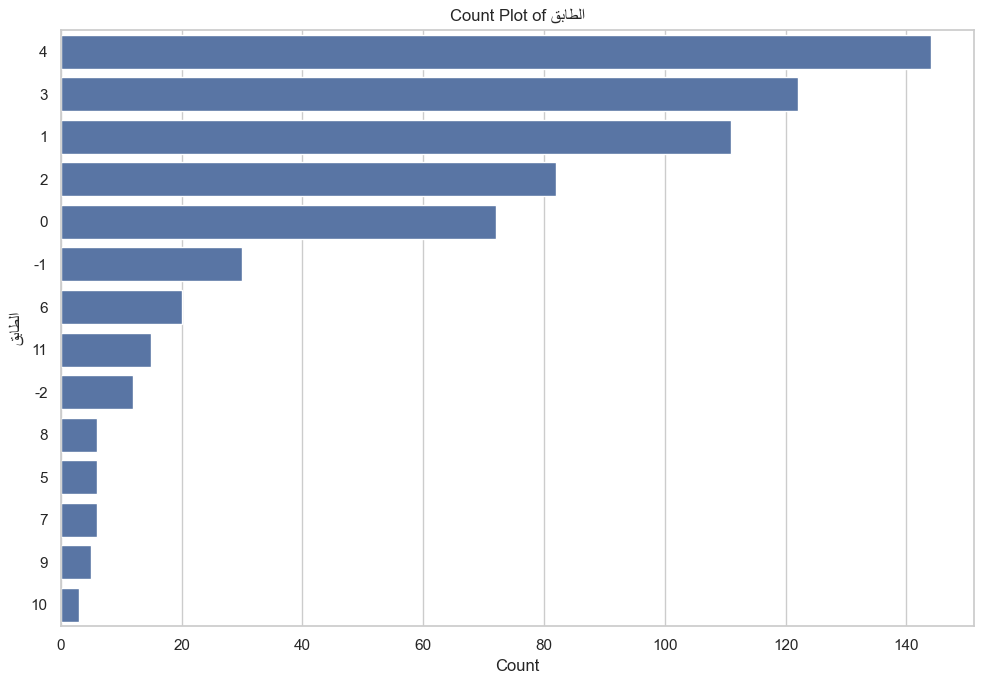

In [17]:
# Manually define the list of categorical features including the newly corrected ones
categorical_features = ['المدينة', 'الحي / المنطقة', 'مفروشة', 'العقار مرهون', 'مصعد', 'موقف سيارات', 'الطابق']

# Create count plots for each of these features
for feature in categorical_features:
    print(f"\n{'='*50}")
    print(f"Feature: {feature}")
    print(f"{'='*50}")
    
    # Use value_counts() to get both the feature values and their counts, then sort by count
    counts = df[feature].value_counts()
    
    print("Value counts:")
    for value, count in counts.items():
        print(f"  {value}: {count}")
    
    print(f"\nTotal unique values: {len(counts)}")
    print(f"Most common: {counts.index[0]} ({counts.iloc[0]} occurrences)")
    print(f"Least common: {counts.index[-1]} ({counts.iloc[-1]} occurrences)")
    
    plt.figure(figsize=(10, 7))
    
    # Process labels for correct Arabic display (only for plots)
    labels = [process_arabic_text(str(label)) for label in counts.index]
    
    sns.barplot(y=counts.index.astype(str), x=counts.values, orient='h', order=counts.index.astype(str))
    
    plt.title(f'Count Plot of {process_arabic_text(feature)}')
    plt.xlabel('Count')
    plt.ylabel(process_arabic_text(feature))
    plt.yticks(plt.gca().get_yticks(), labels) # Set custom labels for y-axis
    plt.tight_layout()
    plt.show()

The categorical analysis shows that the dataset is highly imbalanced across cities, with Ramallah & Al-Bireh dominating and several cities having very few listings, confirming the need for targeted data augmentation for under-represented cities. The neighborhood feature has excessive cardinality (109 unique values, most appearing only once) and will be dropped to reduce noise. Other categorical features such as furnishing status, mortgage status, elevator, and parking are clean, low-cardinality, and ready for encoding. The floor variable has a reasonable distribution and will be treated as an ordered categorical feature to capture its potential non-linear effect on price.

In [18]:
# Drop the 'الحي / المنطقة' column from the dataframe
df.drop('الحي / المنطقة', axis=1, inplace=True)

### Price Relationship with Categorical Features

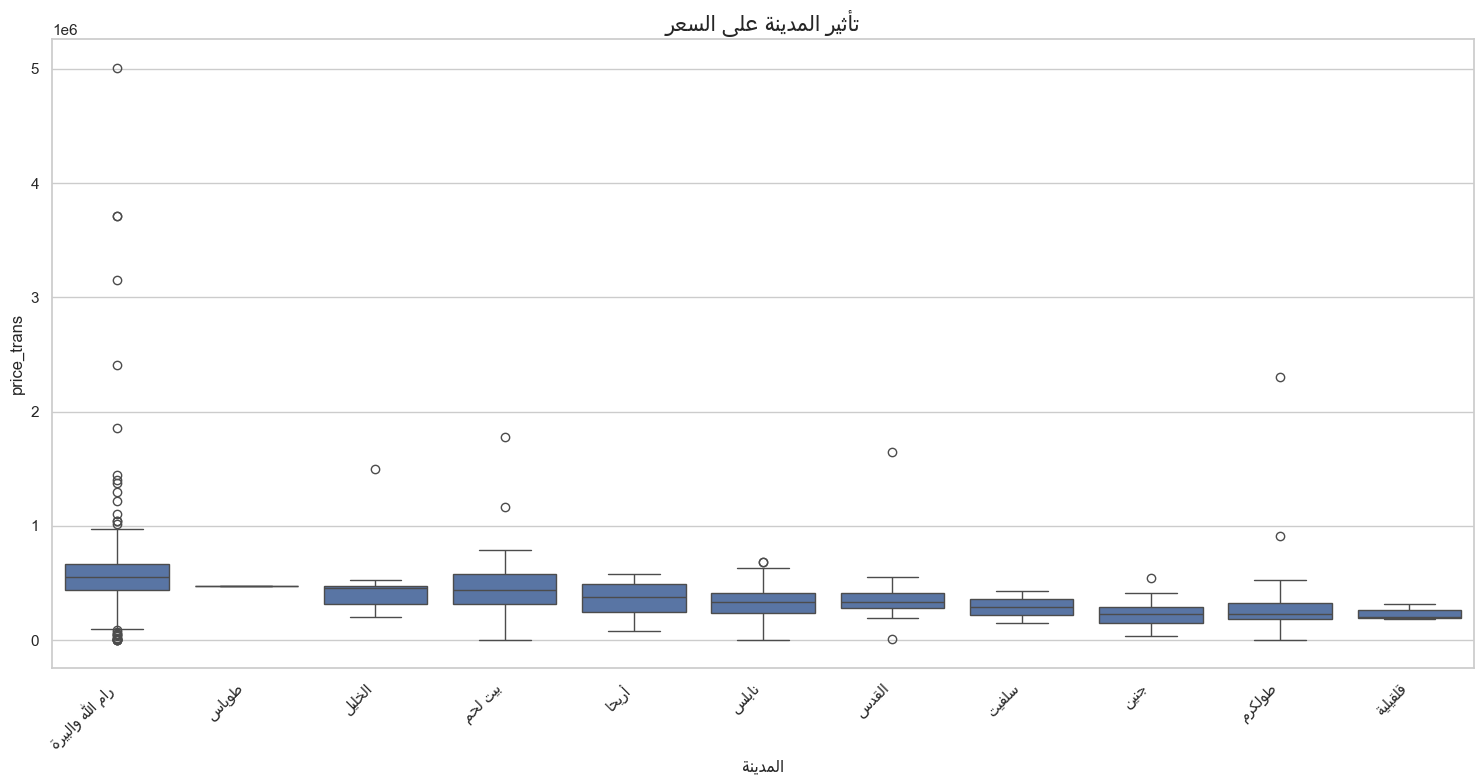

In [19]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial Unicode MS' # Ensure font is set for Arabic

# Box plot for City vs. Price
plt.figure(figsize=(15, 8))

# Order the cities by their median price for a cleaner plot
city_order = df.groupby('المدينة')['price_trans'].median().sort_values(ascending=False).index
processed_labels = [process_arabic_text(label) for label in city_order]

sns.boxplot(data=df, x='المدينة', y='السعر بالشيكل', order=city_order)

plt.title(process_arabic_text('تأثير المدينة على السعر'), fontsize=16)
plt.xlabel(process_arabic_text('المدينة'), fontsize=12)
plt.ylabel(process_arabic_text('price_trans'), fontsize=12)
plt.xticks(ticks=range(len(processed_labels)), labels=processed_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

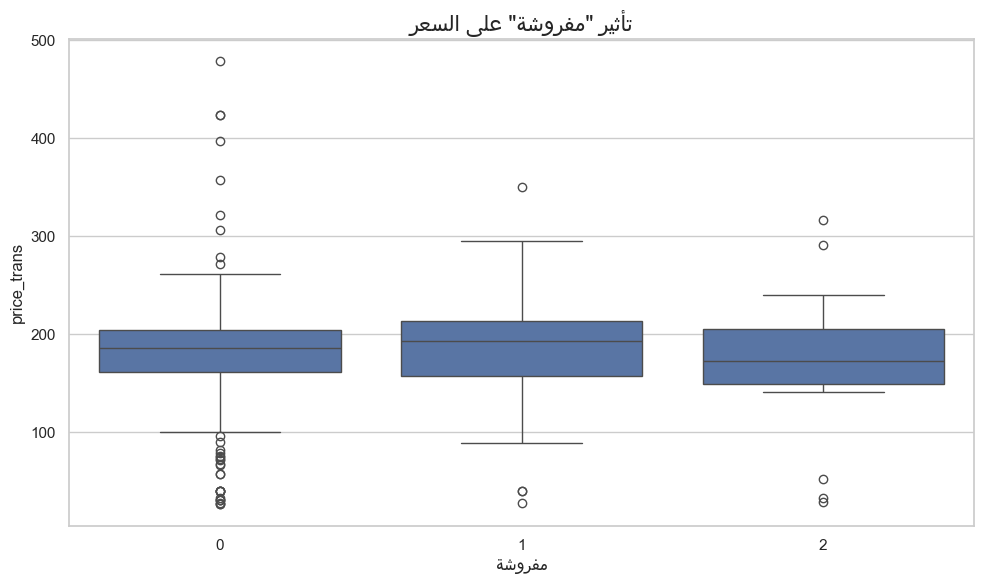

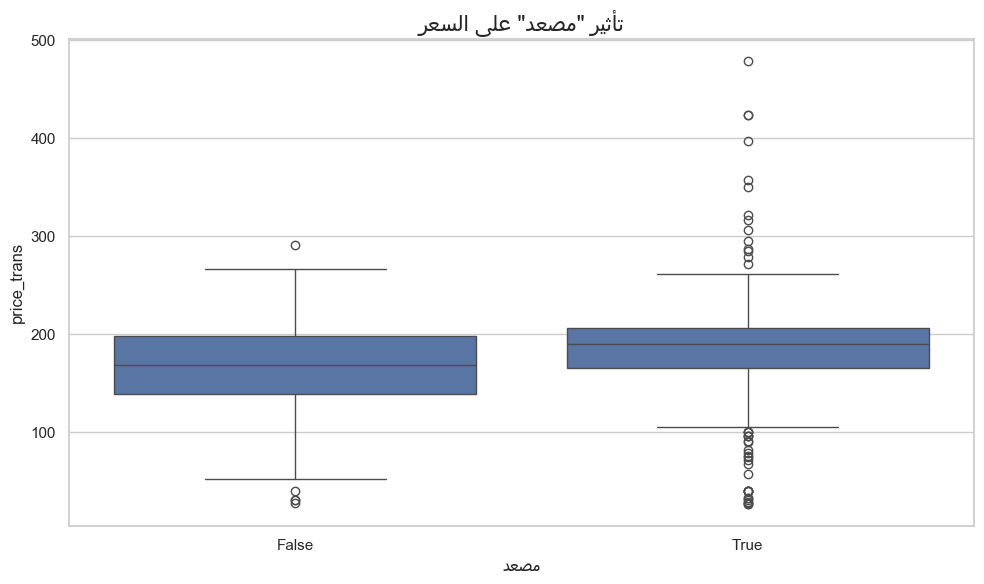

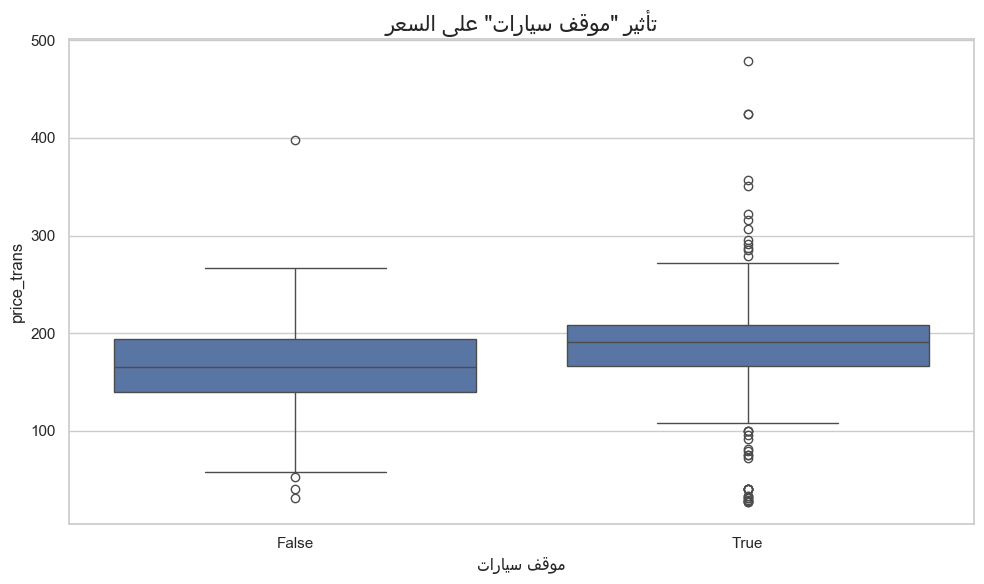

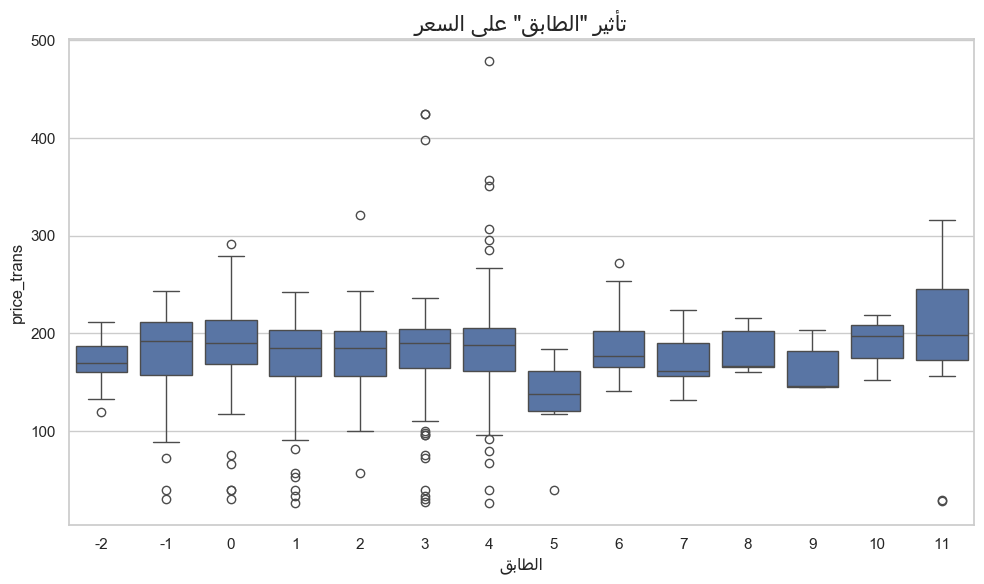

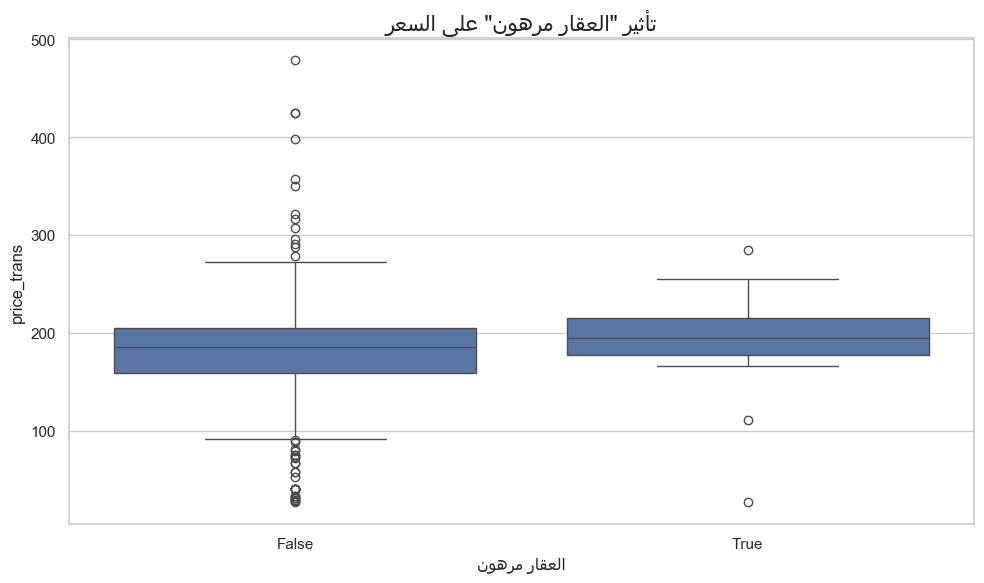

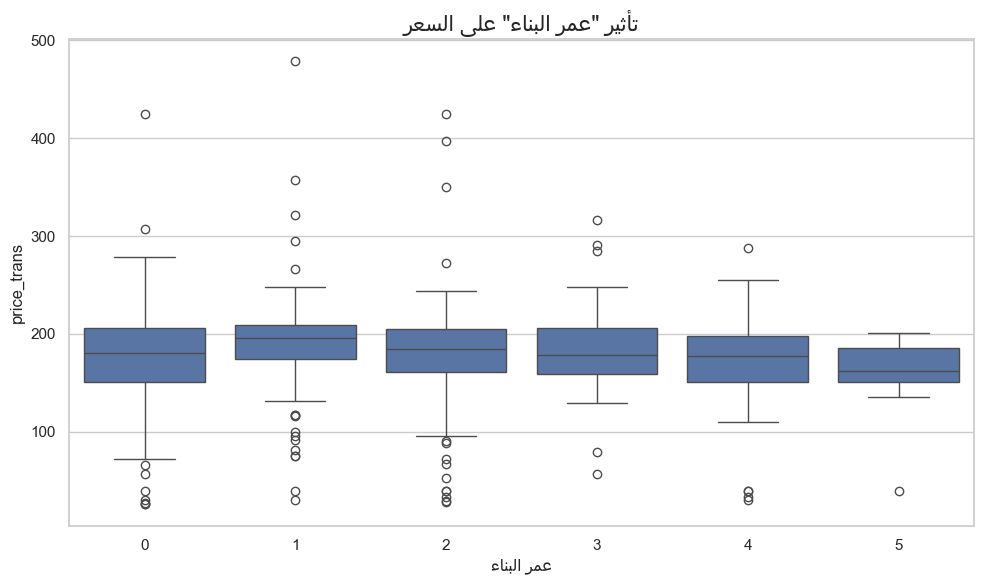

In [20]:
other_categorical_features = ['مفروشة', 'مصعد', 'موقف سيارات', 'الطابق', 'العقار مرهون', 'عمر البناء']

# Generate a box plot for each feature against the price
for feature in other_categorical_features:
    plt.figure(figsize=(10, 6))
    
    # For 'الطابق' (Floor), it's better to sort the x-axis numerically
    order = sorted(df[feature].unique()) if feature == 'الطابق' else None
    
    sns.boxplot(data=df, x=feature, y='price_trans', order=order)
    
    # Create titles and labels
    title_text = process_arabic_text(f'تأثير "{feature}" على السعر')
    xlabel_text = process_arabic_text(feature)
    ylabel_text = process_arabic_text('price_trans')
    
    plt.title(title_text, fontsize=16)
    plt.xlabel(xlabel_text, fontsize=12)
    plt.ylabel(ylabel_text, fontsize=12)
    plt.tight_layout()
    plt.show()

Based on our feature analysis, we've identified significant class imbalance in the city distribution. To address this in our modeling phase, we will implement:
- Bootstrap Sampling: Oversample properties from underrepresented cities to ensure adequate training representation.
- Gaussian Noise Augmentation: Add controlled variations to continuous features when duplicating samples to create realistic diversity while preserving the data relationships observed in our correlation analysis.
These techniques will help our model generalize better across all cities while maintaining the key feature relationships, particularly the strong correlations between area, bathrooms, and price.

In [21]:
df.to_csv('Apts.csv')